In [1]:
# Native libraries
import os
import math
# Essential Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Preprocessing
from sklearn.preprocessing import MinMaxScaler
# Algorithms
#from minisom import MiniSom
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans

In [2]:
from statsmodels.tsa.seasonal import seasonal_decompose
def decompose(df, share_type='amount', samples=250, period=24):
    if samples == 'all':
        #decomposing all time series timestamps
        res = seasonal_decompose(df[share_type].values, model='additive', period=period)
    else:
        #decomposing a sample of the time series
        res = seasonal_decompose(df[share_type].values[-samples:], model='additive', period=period)
    
    observed = res.observed
    trend = res.trend
    seasonal = res.seasonal
    residual = res.resid
    
    #plot the complete time series
    fig, axs = plt.subplots(4, figsize=(20,6))
    axs[0].set_title('OBSERVED', fontsize=14)
    axs[0].plot(observed)
    axs[0].grid()
    
    #plot the trend of the time series
    axs[1].set_title('TREND', fontsize=14)
    axs[1].plot(trend)
    axs[1].grid()
    
    #plot the seasonality of the time series. 
    #Period=24 daily seasonality | Period=24*7 weekly seasonality.
    axs[2].set_title('SEASONALITY', fontsize=14)
    axs[2].plot(seasonal)
    axs[2].grid()
    
    #plot the noise of the time series
    axs[3].set_title('NOISE', fontsize=14)
    axs[3].plot(residual)
    axs[3].scatter(y=residual, x=range(len(residual)), alpha=0.5)
    axs[3].grid()
    
    plt.show()

In [3]:
import glob
import pandas as pd

def pd_read_pattern(pattern, filesNo):
    files = glob.glob(pattern)
    print(len(files))
    df = pd.DataFrame()
    fc =0
    for f in files:
        if fc >= filesNo:
            break    
        # Concat Instead of append
        df = pd.concat([df,pd.read_csv(f, low_memory=False)])
        fc += 1
        
        

    return df.reset_index(drop=True)

ztedf = pd_read_pattern('..\ZTE_NBI\CallAccess_FDD_*.csv', 20)
ztedf.head()

96


,Begin Time,End Time,Granularity,SubnetWork ID,SubnetWork Name,ManagedElement ID,Managed Element,eNodeB ID,eNodeB Name,E-UTRAN FDD Cell ID,...,Number of Cell DRB Admission Failure due to Not Enough CPU Resource(times),Number of Cell DRB Admission Failure due to PHY Resource Allocated Failure(times),Number of Cell Admission Failure due to Service Cell Other Parameters Modification(times),Number of Cell Admission Failure due to Target PLMN selected Failure(times),Number of Cell Admission Failure due to RRC Connection Number License Prohibit(times),Number of Cell Admission Failure due to E-RAB Number License Prohibit(times),Cell Service Time(s),Maximum Number of RRC Connection User(unit),Number of E-RAB HO Incoming Admission Request(unit),Number of E-RAB(QCI7) HO Incoming Admission Request(unit)
0,2023-01-31 00:00:00,2023-01-31 00:15:00,15 minutes,1,1(1),5003,PAF003(5003),280-20_5003,PAF003,21,...,0,0,0,0,0,0,900,9,16,1
1,2023-01-31 00:00:00,2023-01-31 00:15:00,15 minutes,1,1(1),5003,PAF003(5003),280-20_5003,PAF003,22,...,0,0,0,0,0,0,900,13,14,3
2,2023-01-31 00:00:00,2023-01-31 00:15:00,15 minutes,1,1(1),5003,PAF003(5003),280-20_5003,PAF003,23,...,0,0,0,0,0,0,900,13,52,5
3,2023-01-31 00:00:00,2023-01-31 00:15:00,15 minutes,1,1(1),5003,PAF003(5003),280-20_5003,PAF003,31,...,0,0,0,0,0,0,900,2,1,0
4,2023-01-31 00:00:00,2023-01-31 00:15:00,15 minutes,1,1(1),5003,PAF003(5003),280-20_5003,PAF003,32,...,0,0,0,0,0,0,900,2,18,3


In [4]:
df = ztedf.copy()
metrics_list = df.columns.tolist()[14:]

import numbers
import numpy as np
#isinstance(df[m], numbers.Number),
metrics_list_fin = []
for m in metrics_list:
    #print('{} {}'.format(m,df[m].dtype))
    if df[m].dtype == np.int64 or df[m].dtype == np.float64:
        r = df[m].sum()
        if r != 0:
            metrics_list_fin.append(m)
            #print(m)
#df.info()
#metrics_list_fin
print(len(metrics_list))
print(len(metrics_list_fin))

181
76


In [5]:
# Granularity 15 minutes
#df.columns.tolist()[3:14]
eNodeB = ztedf['eNodeB Name'].unique()
cellName = ztedf['E-UTRAN\xa0FDD\xa0Cell Name'].unique()

In [8]:
# Check for missing values
columns_missing_values = {}
df = ztedf.copy()
for c in df.columns:
    msv = df[df[c].isna()| df[c].eq(' ')].shape[0]
    if msv > 0:
        columns_missing_values[c] = (msv,msv/df.shape[0]*100)
    
columns_missing_values

{'Number of Successful Access Using Group A Preamble(unit)': (458,
  0.2294796123898949),
 'Number of Successful Access Using Group B Preamble(unit)': (458,
  0.2294796123898949),
 'Number of Available Preamble(unit)': (458, 0.2294796123898949),
 'Number of Available Dedicated Preamble(unit)': (458, 0.2294796123898949),
 'Number of  Msg0 Scheduled by ENB(times)': (458, 0.2294796123898949),
 'Number of  Msg0 Scheduled by ENB Because of SRS Jump(unit)': (458,
  0.2294796123898949),
 'Number of  Msg0 Scheduled by ENB Because of UL HARQ Fail(unit)': (458,
  0.2294796123898949),
 'Number of  Msg0 Scheduled by ENB Because of DL HARQ Fail(unit)': (458,
  0.2294796123898949),
 'Number of PDCCH Order Non-contention Msg1(unit)': (458, 0.2294796123898949),
 'Number of Non-Contention Handover Msg1(unit)': (458, 0.2294796123898949),
 'Number of Msg1 discarded(times)': (458, 0.2294796123898949),
 'Number of Reducing contention Msg1 False Alarm Based on TA Threshold(unit)': (458,
  0.2294796123898949

In [18]:
df = ztedf.copy()
df = df.dropna().reset_index().drop('index',axis=1)

#https://towardsdatascience.com/hands-on-climate-time-series-clustering-using-machine-learning-with-python-6a12ce1607f9
#time_series_data = df.dropna().reset_index().drop('index',axis=1)
#time_series_data['datetime'] = pd.to_datetime(time_series_data['Begin Time'])
#time_series_data.head()


#df[metrics_list].corr().style.background_gradient(cmap='coolwarm', vmin=0.269278, vmax=1)

C:\Users\GeorgiosCh\AppData\Local\Temp\2\ipykernel_3348\3930502968.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df  = df.groupby(['datetime']).mean()


array([<Axes: xlabel='datetime'>, <Axes: xlabel='datetime'>,
       <Axes: xlabel='datetime'>, <Axes: xlabel='datetime'>,
       <Axes: xlabel='datetime'>, <Axes: xlabel='datetime'>,
       <Axes: xlabel='datetime'>, <Axes: xlabel='datetime'>,
       <Axes: xlabel='datetime'>, <Axes: xlabel='datetime'>], dtype=object)

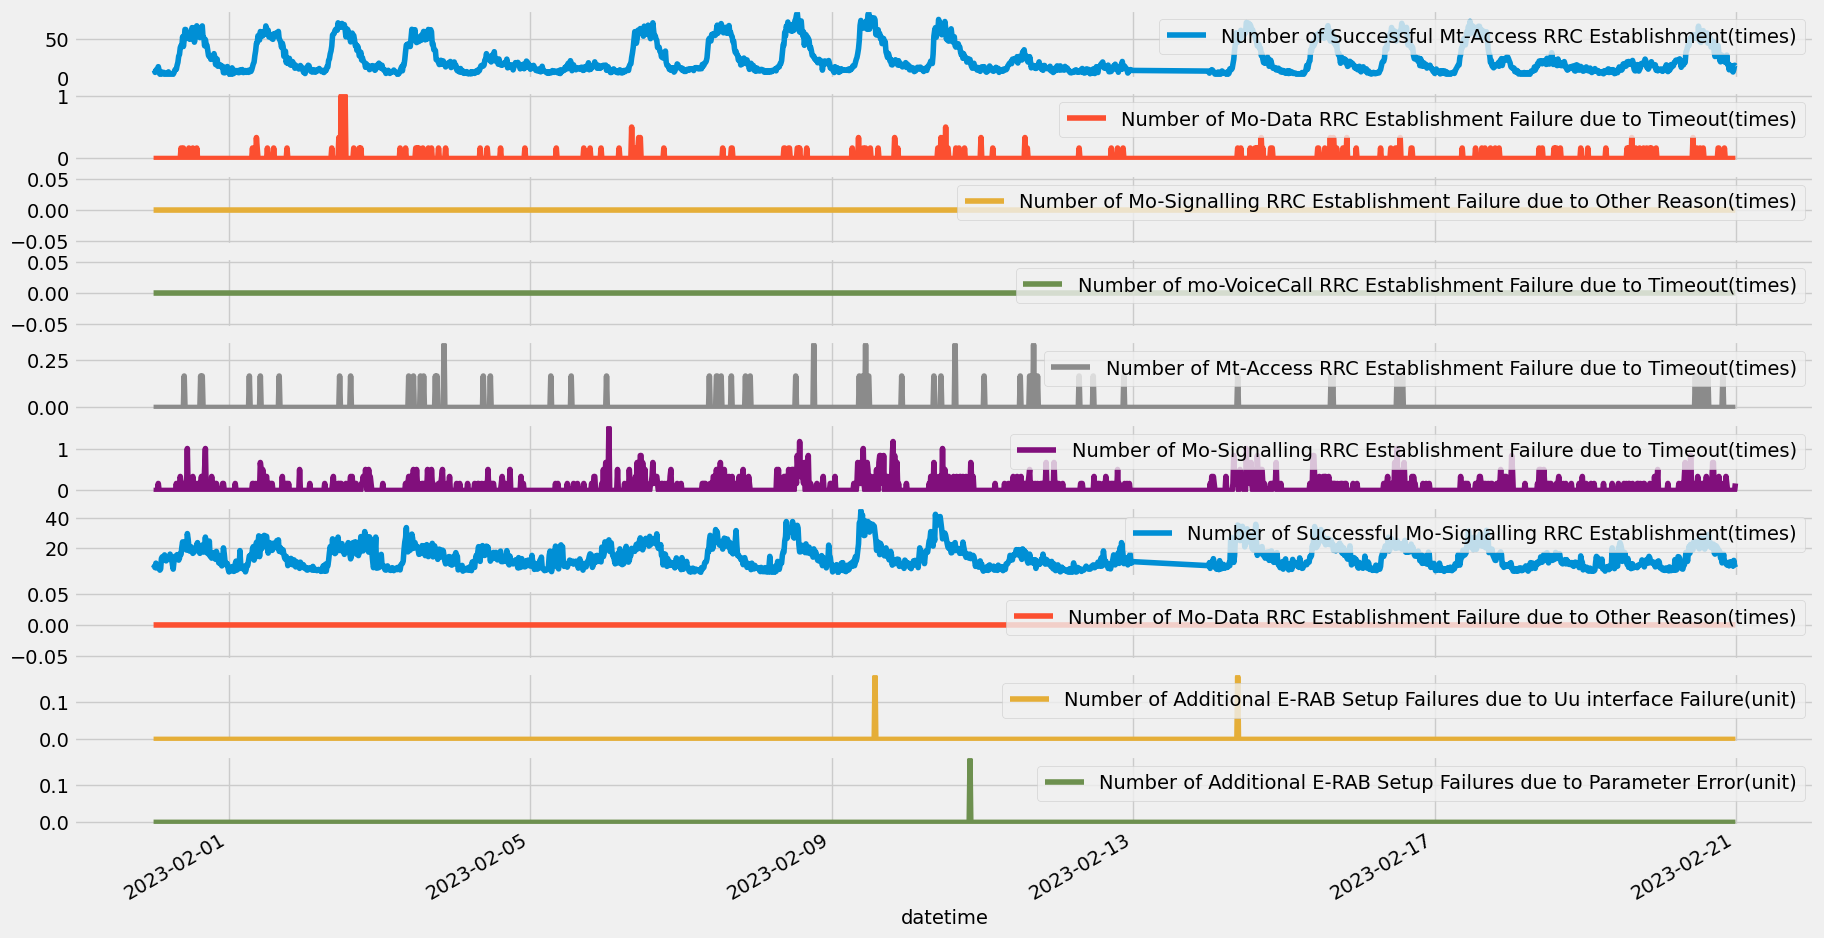

In [6]:
df = ztedf.loc[ztedf['eNodeB Name']=='LIM045'].copy()
df['datetime'] = pd.to_datetime(df['Begin Time'])
#df['datetime'] = df['date'].dt.strftime('%Y%m') 
df  = df.groupby(['datetime']).mean()
 
# Using a inbuilt style to change
# the look and feel of the plot
plt.style.use("fivethirtyeight")
 
df[metrics_list_fin[0:10]].plot(subplots=True, figsize=(20, 12))

In [7]:
df[metrics_list[0:2]].corr().style.background_gradient(cmap='coolwarm', vmin=0.269278, vmax=1)

,Number of Successful Mt-Access RRC Establishment(times),Number of Mo-Data RRC Establishment Failure due to Timeout(times)
Number of Successful Mt-Access RRC Establishment(times),1.000000,0.200159
Number of Mo-Data RRC Establishment Failure due to Timeout(times),0.200159,1.000000


### Multivariate Feature Selection
https://scikit-learn.org/stable/modules/feature_selection.html

In [8]:
from sklearn.feature_selection import VarianceThreshold

df = ztedf.loc[ztedf['eNodeB Name']=='LIM045'].copy()
df['datetime'] = pd.to_datetime(df['Begin Time'])

sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
x = sel.fit_transform(df[metrics_list_fin])
lable = sel.get_feature_names_out()

In [9]:
dfnew = pd.DataFrame(data=x, columns=lable)
print(dfnew.shape)
df2 = df['datetime'].to_frame().reset_index()
print(df2.shape)

#df2 = pd.concat([df2, dfnew], axis=0)
#df2.shape
df2 = pd.merge(df2,dfnew, right_index=True, left_index=True)
df2.shape
#pd.merge(dfnew,df[list('datetime')])
#dfnew.merge(df[['datetime']])

(11520, 19)
(11520, 2)


(11520, 21)

In [10]:
df2.describe().T

,count,mean,std,min,25%,50%,75%,max
index,11520.0,98522.022917,56756.119871,72.0,50293.75,97847.5,146370.25,199581.0
Number of Successful Mt-Access RRC Establishment(times),11520.0,24.624306,24.592486,0.0,6.00,16.0,36.00,172.0
Number of Successful Mo-Signalling RRC Establishment(times),11520.0,13.641667,15.025223,0.0,3.00,9.0,19.00,118.0
Number of Successful Context Modify (times),11520.0,0.856684,1.628443,0.0,0.00,0.0,1.00,15.0
Number of Mo-Signalling RRC Establishment Request(times),11520.0,13.724740,15.084144,0.0,3.00,9.0,19.00,118.0
Number of Mt-Access RRC Establishment Request(times),11520.0,24.629687,24.597929,0.0,6.00,16.0,36.00,172.0
Number of Successful RRC Connection Re-establishment Triggered by Handover Failure(times),11520.0,0.162760,0.701951,0.0,0.00,0.0,0.00,22.0
Number of Successful RRC Connection Re-establishment Triggered by Other(times),11520.0,0.264670,0.993687,0.0,0.00,0.0,0.00,48.0
Number of RRC Connection Re-establishment Request Triggered by Other(times),11520.0,0.352083,1.099051,0.0,0.00,0.0,0.00,48.0
Number of RRC Connection Re-establishment Request Triggered by Handover Failure(times),11520.0,0.170139,0.716439,0.0,0.00,0.0,0.00,22.0


array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >], dtype=object)

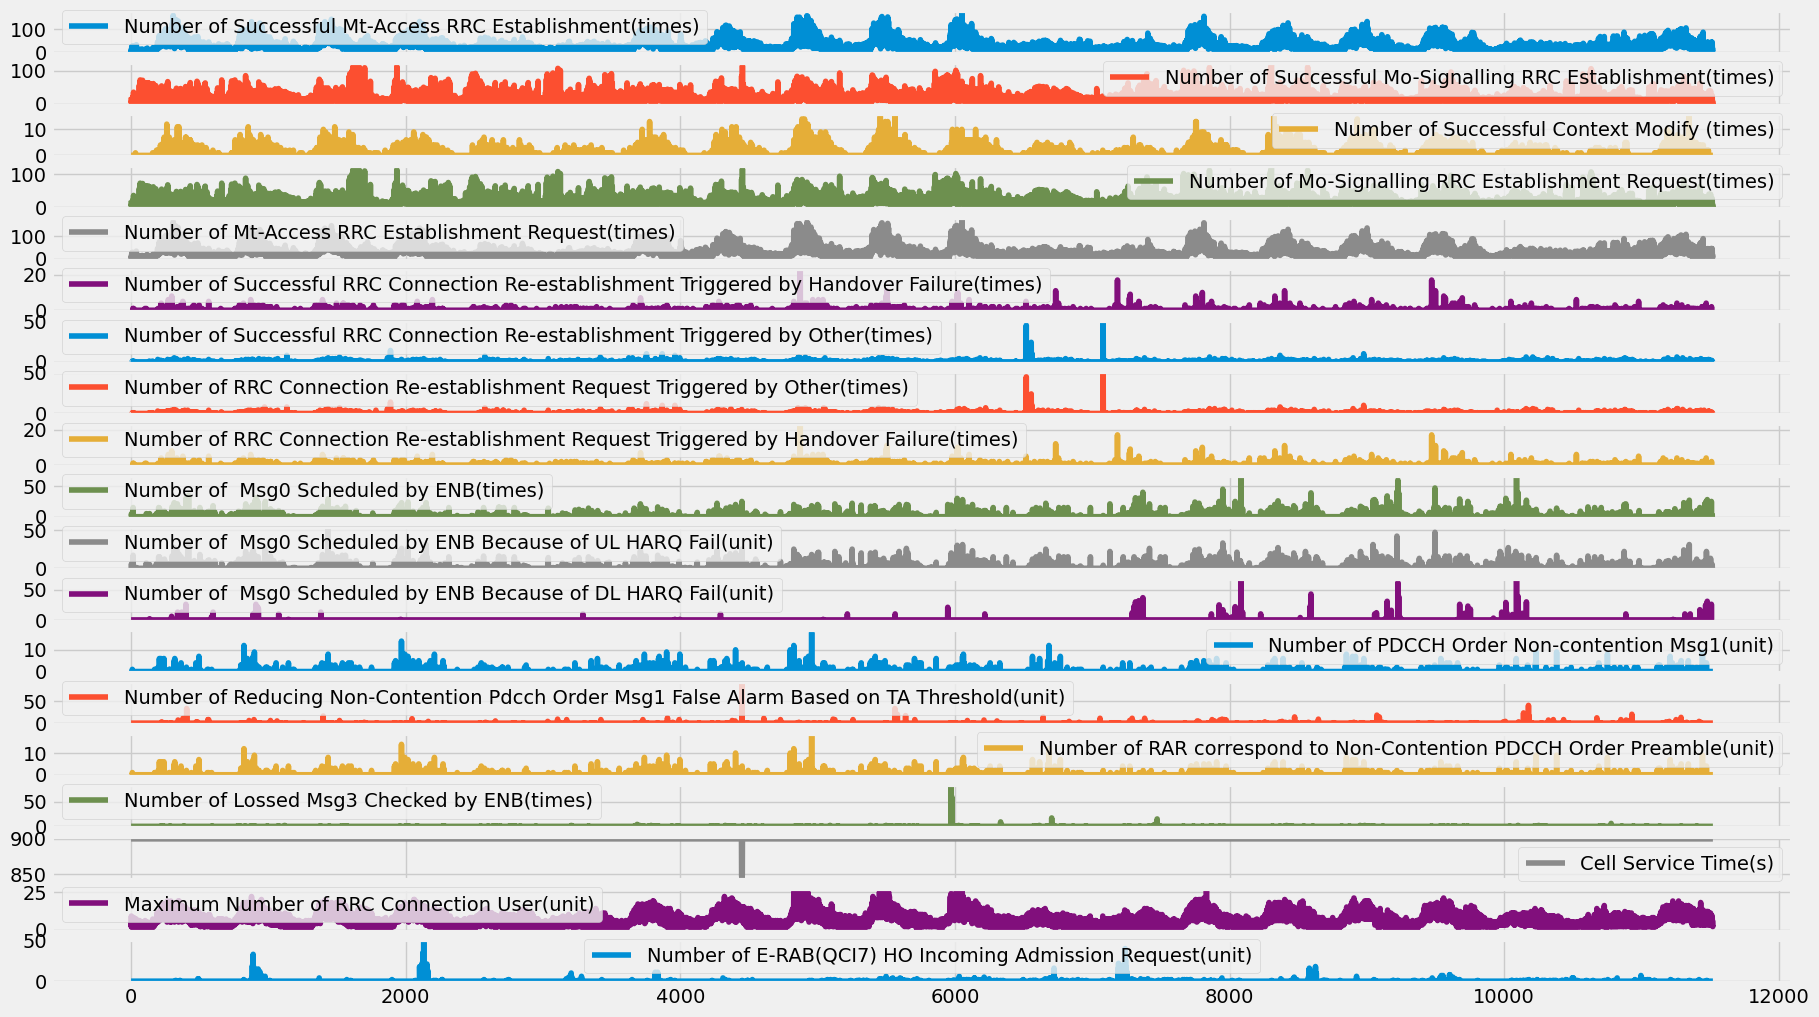

In [11]:
df2[lable].plot(subplots=True, figsize=(20, 12))

In [12]:
# Min Max Scaler
scaler = MinMaxScaler((0, 1))
ts = df2.copy()
ts2 = scaler.fit_transform(ts[lable])

for i in range(len(lable)):
    ts[lable[i]] = ts2.T[i]

ts.shape

(11520, 21)

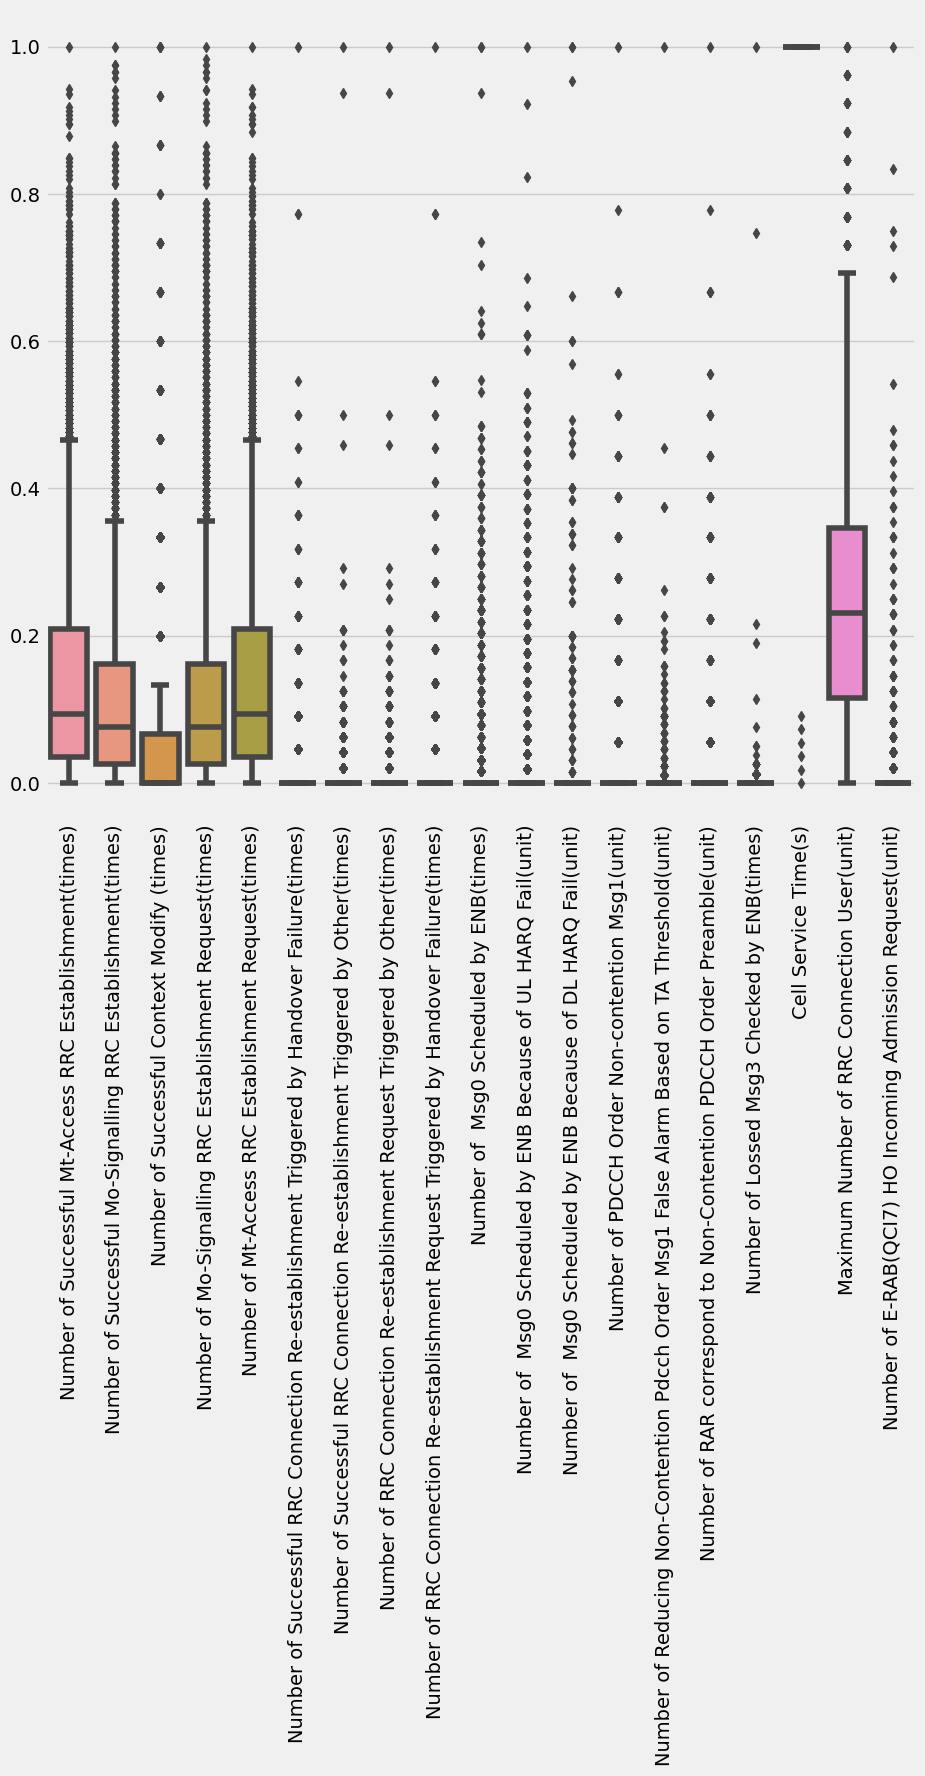

In [13]:
### Plot Outliers
import seaborn as sns # data visualization library  
plt.figure(figsize=(10,10))
sns.boxplot(data=ts[lable])
plt.xticks(rotation=90)
plt.show()

#### Decompose Time-Series to See Components (Trend, Seasonality, Noise, etc)

In [132]:
from statsmodels.tsa.seasonal import seasonal_decompose

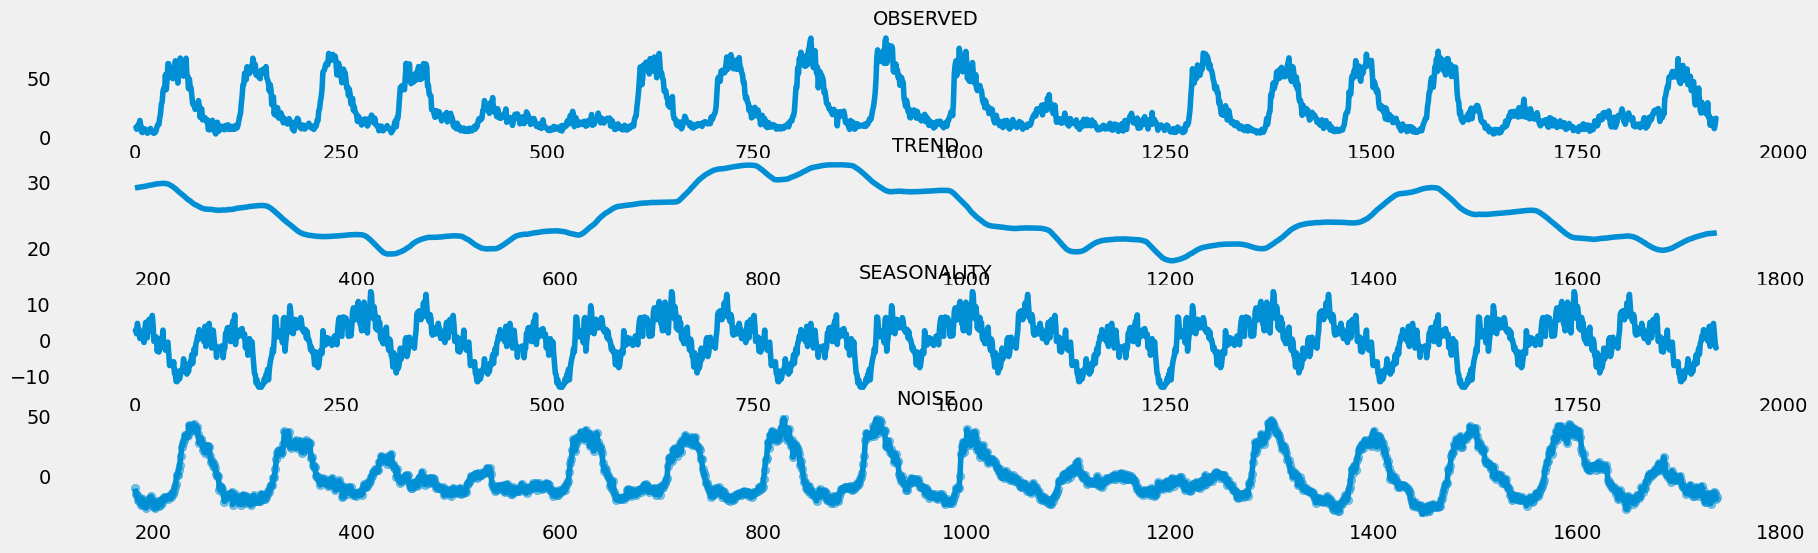

Number of Successful Mt-Access RRC Establishment(times)


In [157]:
df_plt = df2.copy() 
col = df_plt.columns.values[2]
df_plt = df_plt.groupby('datetime').mean().reset_index()
decompose(df_plt,col, 2000,365)
print(col)
#sd = seasonal_decompose(df2[lable[2]][1:1000], model='additive', period=3)
#sd.plot()

#### Predictions